In [25]:
import numpy as np
import h5py as h5
from tqdm import tqdm
from scipy.spatial import ConvexHull
import matplotlib.pyplot as plt
import matplotlib as mpl

In [5]:
basepath = '/n/holylfs05/LABS/hernquist_lab/Users/abeane/gasbar/'
in_bar_path = basepath + '/analysis/in_bar/data/'
phase_space_path = basepath + '/analysis/phase_space/data/'

nchunk = 256

In [92]:
name = 'Nbody'
lvl = 'lvl3'
idx = 500

def get_pos_ib(name, lvl, idx):

    pos_ib = []

    for i in tqdm(range(nchunk)):
        h5ib = h5.File(in_bar_path + 'in_bar_'+name+'-'+lvl+'/in_bar_'+name+'-'+lvl+'.'+str(i)+'.hdf5', mode='r')
        h5ps = h5.File(phase_space_path +name+'-'+lvl+'/phase_space_'+name+'-'+lvl+'.'+str(i)+'.hdf5', mode='r')
    
        pos_ib.append( h5ps['PartType2/Coordinates'][:,idx,:][h5ib['PartType2/in_bar'][idx]] )
        pos_ib.append( h5ps['PartType3/Coordinates'][:,idx,:][h5ib['PartType3/in_bar'][idx]] )
        if 'PartType4' in h5ps.keys():
            pos_ib.append( h5ps['PartType4/Coordinates'][:,idx,:][h5ib['PartType4/in_bar'][idx]] )
    
        h5ib.close()
        h5ps.close()

    pos_ib = np.concatenate(pos_ib)
    
    return pos_ib


In [93]:
pos_ib_Nbody = get_pos_ib('Nbody', 'lvl3', 500)

100%|██████████| 256/256 [08:00<00:00,  1.88s/it]


In [94]:
pos_ib_SMUGGLE = get_pos_ib('phantom-vacuum-Sg20-Rc3.5', 'lvl3', 200)

100%|██████████| 256/256 [06:12<00:00,  1.46s/it]


In [ ]:
r = np.linalg.norm(pos_ib, axis=1)
r99 = np.percentile(r, 99)
key = r < r99

hull = ConvexHull(pos_ib[key])

[(-10.0, 10.0), (-10.0, 10.0)]

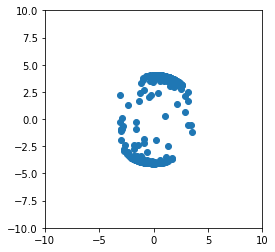

In [30]:
fig, ax = plt.subplots(1, 1)
ax.scatter(pos_ib[key][hull.vertices, 0], pos_ib[key][hull.vertices, 1])
ax.set_aspect('equal')
ax.set(xlim=(-10, 10), ylim=(-10, 10))


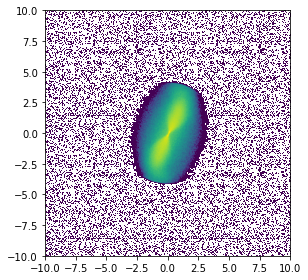

In [26]:
nres = 512

range_xy = [[-10, 10], [-10, 10]]
# center = np.array([200., 200., 200.])

x = pos_ib[key][:,0]
y = pos_ib[key][:,1]
heatmap_xy, _, _ = np.histogram2d(x, y, bins=(nres, nres), range=range_xy)
# heatmap_xy = gaussian_filter(heatmap_xy, sigma=16)

extent = [range_xy[0][0], range_xy[0][1], range_xy[1][0], range_xy[1][1]]

fig, ax = plt.subplots(1, 1)

ax.imshow(heatmap_xy.T, extent=extent, origin='lower', norm=mpl.colors.LogNorm())
ax.set_aspect('equal')
fig.tight_layout()

plt.show()


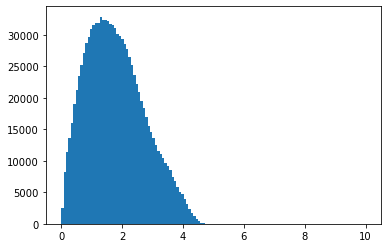

In [95]:
R_ib = np.linalg.norm(pos_ib_Nbody[:,:2], axis=1)
plt.hist(R_ib, bins=np.linspace(0, 10, 128));

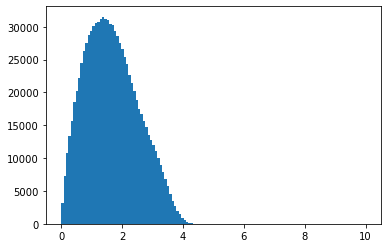

In [98]:
center = np.array([200., 200., 200.])
R_ib = np.linalg.norm(pos_ib_SMUGGLE[:,:2] - center[:2], axis=1)
plt.hist(R_ib, bins=np.linspace(0, 10, 128));

array([[200.68322459, 199.75668258, 200.46559175],
       [199.07996284, 200.11382264, 200.3599861 ],
       [197.63355786, 201.34639053, 200.75218249],
       ...,
       [200.66627471, 199.70684589, 200.07976028],
       [200.04393982, 199.91261529, 199.94626049],
       [200.09553419, 199.94223629, 199.96629768]])

### Disk subtraction

In [35]:
import arepo

In [36]:
sim_list = ['Nbody', 'phantom-vacuum-Sg20-Rc3.5', 'phantom-vacuum-Sg10-Rc3.5']

basepath = '/n/holystore01/LABS/hernquist_lab/Users/abeane/starbar_runs/runs/'

def read_snap(idx, sim_idx, lvl='lvl3', parttype=[0], 
              fields=['Coordinates', 'Masses', 'Velocities', 'ParticleIDs', 'Potential'],
              basepath = basepath):
    
    fname = basepath + sim_list[sim_idx] + '/' + lvl + '/output'
    return arepo.Snapshot(fname, idx, parttype=parttype, fields=fields, combineFiles=True)

def read_sfr(sim_idx, lvl='lvl3', basepath = basepath):
    fname = basepath + sim_list[sim_idx] + '/' + lvl + '/output/sfr.txt'
    return np.genfromtxt(fname)

def read_fourier(sim_idx, lvl='lvl3', basepath='/n/holylfs05/LABS/hernquist_lab/Users/abeane/gasbar/analysis/'):
    sim = sim_list[sim_idx]
    f = h5.File(basepath+'/fourier_component/data/fourier_'+sim+'-'+lvl+'.hdf5', mode='r')
    return f

In [39]:
def rotate_pos(pos, ang):

    Rmat = np.array([[np.cos(ang), -np.sin(ang), 0.0],
                     [np.sin(ang),  np.cos(ang), 0.0],
                     [0.0,         0.0,          1.0]])
    
    pos = np.swapaxes(pos, 0, 1)
    pos = np.matmul(Rmat, pos)
    pos = np.swapaxes(pos, 0, 1)
    
    return pos

In [62]:
nres = 256
L = 5
range_xy = [[-L, L], [-L, L]]
extent = [range_xy[0][0], range_xy[0][1], range_xy[1][0], range_xy[1][1]]

In [37]:
sn0 = read_snap(0, 1, parttype=None, fields=None)
sn50 = read_snap(50, 1, parttype=None, fields=None)

In [59]:
def get_heatmap(sn):
    center = sn.part1.pos.value[np.argmin(sn.part1.pot.value)]
    
    pos = []
    mass = []
    for i in [2, 3, 4]:
        if sn.NumPart_Total[i]>0:
            part = getattr(sn, 'part'+str(i))
            pos.append(part.pos.value - center)
            
            if sn.MassTable[i] > 0.0:
                mass.append(np.full(sn.NumPart_Total[i], sn.MassTable[i]))
            else:
                mass.append(part.mass.value)
    
    pos = np.concatenate(pos)
    mass = np.concatenate(mass)
    
    # rotate pos
    R = np.linalg.norm(pos[:,:2], axis=1)
    phi = np.arctan2(pos[:,1], pos[:,0])
    
    key = np.logical_and(R > 0.1, R < 4)
    
    A2r = np.sum(mass[key] * np.cos(2*phi[key]))
    A2i = np.sum(mass[key] * np.sin(2*phi[key]))
    phi_bar = np.arctan2(A2i, A2r)/2.
    
    pos = rotate_pos(pos, -phi_bar)
    
    heatmap_xy, _, _ = np.histogram2d(pos[:,0], pos[:,1], bins=(nres, nres), range=range_xy, weights=mass)
    
    return heatmap_xy
    

In [60]:
plt.close()

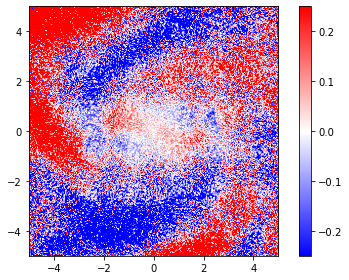

In [63]:
heatmap0 = get_heatmap(sn0)
heatmap50 = get_heatmap(sn50)

fig, ax = plt.subplots(1, 1)

im = ax.imshow((heatmap50.T - heatmap0.T)/heatmap0.T, extent=extent, origin='lower', cmap='bwr',
              vmin=-0.25, vmax=0.25)
fig.colorbar(im, ax=ax)
ax.set_aspect('equal')
fig.tight_layout()

plt.show()

### A2 f'n of radius

In [64]:
def get_pos_mass(sn):
    center = sn.part1.pos.value[np.argmin(sn.part1.pot.value)]
    
    pos = []
    mass = []
    for i in [2, 3, 4]:
        if sn.NumPart_Total[i]>0:
            part = getattr(sn, 'part'+str(i))
            pos.append(part.pos.value - center)
            
            if sn.MassTable[i] > 0.0:
                mass.append(np.full(sn.NumPart_Total[i], sn.MassTable[i]))
            else:
                mass.append(part.mass.value)
    
    pos = np.concatenate(pos)
    mass = np.concatenate(mass)
    
    return pos, mass

def compute_A2_bins(sn):
    pos, mass = get_pos_mass(sn)
    
    R = np.linalg.norm(pos[:,:2], axis=1)
    phi = np.arctan2(pos[:,1], pos[:,0])
    
    dR = 0.5
    Rmin = 0
    Rlist = []
    A2list = []
    A0list = []
    
    while Rmin < 15.0:
        key = np.logical_and(R >= Rmin, R < Rmin + dR)
        
        A0 = np.sum(mass[key])
        A2r = np.sum(mass[key] * np.cos(2*phi[key]))
        A2i = np.sum(mass[key] * np.sin(2*phi[key]))
        A2 = np.sqrt(A2r**2 + A2i**2)
        
        Rave = np.mean(R[key])
        
        Rlist.append(Rave)
        A2list.append(A2)
        A0list.append(A0)
        
        Rmin += dR
    
    Rlist = np.array(Rlist)
    A2list = np.array(A2list)
    A0list = np.array(A0list)
    
    return Rlist, A2list, A0list
    

In [67]:
R_0, A2_0, A0_0 = compute_A2_bins(sn0)
R_50, A2_50, A0_50 = compute_A2_bins(sn50)

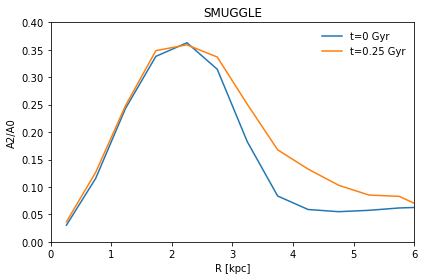

In [78]:
fig, ax = plt.subplots(1, 1)

ax.plot(R_0, A2_0/A0_0, label='t=0 Gyr')
ax.plot(R_50, A2_50/A0_50, label='t=0.25 Gyr')

ax.set(xlim=(0, 6), ylim=(0, 0.4))
ax.set(xlabel='R [kpc]')
ax.set(ylabel='A2/A0')

ax.legend(frameon=False)
ax.set_title('SMUGGLE')

fig.tight_layout()


In [85]:
snN300 = read_snap(300, 0, parttype=None, fields=None)
snN350 = read_snap(350, 0, parttype=None, fields=None)

In [86]:
R_300, A2_300, A0_300 = compute_A2_bins(snN300)
R_350, A2_350, A0_350 = compute_A2_bins(snN350)

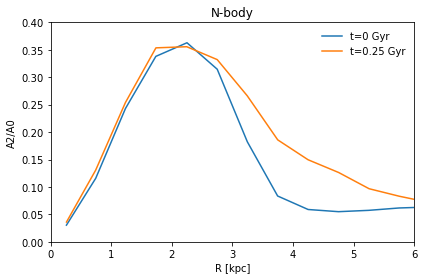

In [88]:
fig, ax = plt.subplots(1, 1)

ax.plot(R_300, A2_300/A0_300, label='t=0 Gyr')
ax.plot(R_350, A2_350/A0_350, label='t=0.25 Gyr')

ax.set(xlim=(0, 6), ylim=(0, 0.4))
ax.set(xlabel='R [kpc]')
ax.set(ylabel='A2/A0')

ax.legend(frameon=False)
ax.set_title('N-body')

fig.tight_layout()
